In [338]:
'''data'''
import pandas as pd
import numpy as np
from datetime import datetime
import math


'''plotting'''
import matplotlib.pyplot as plt
from matplotlib import rc, font_manager
import seaborn as sns

'''sys library'''
#plt.style.use('fivethirtyeight')
import warnings
import os
import gc
warnings.filterwarnings('ignore')
%matplotlib inline
rc('font',family="NanumSquareR")

'''modeling'''
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import catboost as cb
#from ggplot import *
from sklearn.linear_model import LinearRegression
import scipy.stats as st
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import uniform, randint
from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error
#-*- coding: utf-8 -*-

In [339]:
plt.style.use('ggplot') #ggplot스타일 사용
plt.rc('axes', unicode_minus=False)
rc('font', family='AppleGothic')

In [646]:
jeju_df = pd.read_csv('jeju_data_ver1/201901-202003.csv')

In [642]:
real04 = pd.read_csv('202004.csv')

In [649]:
jeju_df = pd.concat([jeju_df,real04],axis = 0)

In [627]:
#2,3월 제외하고 예측
jeju_df = jeju_df[(jeju_df['REG_YYMM'] != 202003) & (jeju_df['REG_YYMM'] != 202002)]

In [152]:
demo_df = pd.read_csv('jeju_data_ver1/Demograpy.csv')

In [650]:
sub_lgb = pd.read_csv('jeju_data_ver1/submission.csv')
sub_xgb = pd.read_csv('jeju_data_ver1/submission.csv')
sub_cat = pd.read_csv('jeju_data_ver1/submission.csv')

In [333]:
sub_rf = pd.read_csv('jeju_data_ver1/submission.csv')

In [6]:
sub_emb = pd.read_csv('jeju_data_ver1/submission.csv')

# ***Data Cleansing***

In [628]:
def data_wrangling(df2):
    
    # 인코딩
    dtypes = df2.dtypes
    encoders = {}
    for column in df2.columns:
        if str(dtypes[column]) == 'object':
            encoder = LabelEncoder()
            encoder.fit(df2[column])
            encoders[column] = encoder

    for column in encoders.keys():
        encoder = encoders[column]
        df2[column] = encoder.transform(df2[column])
        
    return encoders, df2

def ymd_convert(jeju_df):
    year_ls = []
    for i in jeju_df['REG_YYMM'].tolist():
        year_ls.append(int(str(i)[:4]))

    month_ls = []
    for i in jeju_df['REG_YYMM'].tolist():
        month_ls.append(int(str(i)[4:]))

    jeju_df['year'] = year_ls
    jeju_df['month'] = month_ls

    jeju_df.drop(columns = 'REG_YYMM',inplace = True)
    
    df = jeju_df.drop(columns = ['CARD_CCG_NM','HOM_CCG_NM'])

    columns = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month']
    df2 = df.groupby(columns).sum().reset_index(drop=False)

    return df2


***4월 예측 데이터셋***

In [651]:
jeju_df2 = ymd_convert(jeju_df)

In [16]:
# 업종별 작년 3월 -> 4월의 카드 사용량 변동

jeju_month3 = jeju_df2[(jeju_df2['month'] == 3) & (jeju_df2['year'] == 2019)]
jeju_month4 = jeju_df2[(jeju_df2['month'] == 4) & (jeju_df2['year'] == 2019)]

jeju_merge34 = pd.merge(jeju_month4,jeju_month3,on = ['CARD_SIDO_NM','STD_CLSS_NM','HOM_SIDO_NM'\
                                      ,'AGE','SEX_CTGO_CD','FLC'],how = 'left')

# 높아졌거나 다음 달에 값이 없는 경우 1  내려갔을 경우 0
jeju_merge34['variance_month34'] = jeju_merge34.apply(lambda x : 1 if x['AMT_x'] >= x['AMT_y'] or str(x['AMT_y']) == 'nan' else 0,1)

In [28]:
jeju_merge34_ver1 = jeju_merge34[['CARD_SIDO_NM','STD_CLSS_NM','HOM_SIDO_NM'\
                                      ,'AGE','SEX_CTGO_CD','FLC','variance_month34']]

In [33]:
aa = pd.merge(jeju_df2,jeju_merge34_ver1, on = ['CARD_SIDO_NM','STD_CLSS_NM','HOM_SIDO_NM'\
                                      ,'AGE','SEX_CTGO_CD','FLC'],how = 'left')

aa # 흠...왜그러냐

,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month,CSTMR_CNT,AMT,CNT,variance_month34
0,강원,건강보조식품 소매업,강원,20s,1,1,2019,1,4,311200,4,NaN
1,강원,건강보조식품 소매업,강원,20s,1,1,2019,2,3,605000,3,NaN
2,강원,건강보조식품 소매업,강원,20s,1,1,2019,6,3,139000,3,NaN
3,강원,건강보조식품 소매업,강원,20s,1,1,2019,8,3,27500,3,NaN
4,강원,건강보조식품 소매업,강원,20s,1,1,2019,9,3,395500,3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1057389,충북,휴양콘도 운영업,충북,70s,2,5,2019,3,3,148000,4,NaN
1057390,충북,휴양콘도 운영업,충북,70s,2,5,2019,5,5,329800,7,NaN
1057391,충북,휴양콘도 운영업,충북,70s,2,5,2019,10,7,557800,7,NaN
1057392,충북,휴양콘도 운영업,충북,70s,2,5,2019,12,3,247800,3,NaN


In [260]:
#계절 변수
def season_func(x):
    if 3<= x <= 5:
        return '봄'
    elif 6<= x <= 8:
        return '여름'
    elif 9<= x <= 11:
        return '가을'
    else:
        return '겨울'
jeju_df2['season'] = jeju_df2['month'].apply(season_func)

# 업종 대분류
def work_func(x):
    big_cate = x.split(' ')
    return big_cate[-1]

jeju_df2['big_std_clss'] =jeju_df2['STD_CLSS_NM'].apply(work_func)

In [652]:
encoder_real, df2_real = data_wrangling(jeju_df2)

***3월 예측 데이터셋***

In [181]:
jeju_df_remove3 = jeju_df[jeju_df['REG_YYMM'] != 202003]

In [182]:
jeju_df_remove3 = ymd_convert(jeju_df_remove3)

In [183]:
#계절 변수
def season_func(x):
    if 3<= x <= 5:
        return '봄'
    elif 6<= x <= 8:
        return '여름'
    elif 9<= x <= 11:
        return '가을'
    else:
        return '겨울'
jeju_df_remove3['season'] = jeju_df_remove3['month'].apply(season_func)

In [184]:
def work_func(x):
    big_cate = x.split(' ')
    return big_cate[-1]

jeju_df_remove3['big_std_clss'] =jeju_df_remove3['STD_CLSS_NM'].apply(work_func)

In [212]:
# 지역별 인구분포 데이터

demo_df['year'] = demo_df['ym'].apply(lambda x : int(str(x)[:4]))
demo_df['month'] = demo_df['ym'].apply(lambda x : int(str(x)[4:]))

male_df = demo_df[['year','month','location','male']]
female_df = demo_df[['year','month','location','female']]
total_df = demo_df[['year','month','location','total']]

male_df['SEX_CTGO_CD'] = 1
male_df.columns = ['year','month','CARD_SIDO_NM','demon','SEX_CTGO_CD']

female_df['SEX_CTGO_CD'] = 2
female_df.columns = ['year','month','CARD_SIDO_NM','demon','SEX_CTGO_CD']

demo_gender_df = pd.concat([male_df,female_df],axis = 0)


jeju_df3 = pd.merge(jeju_df2,demo_gender_df,on =['year','month','CARD_SIDO_NM','SEX_CTGO_CD'] ,how = 'left')

In [189]:
#columns_ls = list(set(jeju_df_remove3.columns.tolist()) - set(['CARD_CCG_NM','HOM_CCG_NM','AMT','CNT','CSTMR_CNT']))
encoder_remove3, df2_remove3 = data_wrangling(jeju_df_remove3)

In [220]:
encoder_real, df2_real = data_wrangling(jeju_df3)

# ***Default Modeling***

In [653]:
# 4월의 데이터를 예측하는 데이터
# 랜덤으로 샘플링(개수 그대로) - frac : 비율
train_num = df2_real.sample(frac=1, random_state=0)
train_df = train_num.drop(columns = ['CSTMR_CNT','AMT','CNT'])

# loglp -> 로그화를 통해서 데이터의 분포를 수정(왜도가 오른쪽이 긴 꼬리 분포)
target = np.log1p(train_num['AMT'])

In [194]:
# 3월 데이터를 검증셋으로 구축
train_num_remove3 = df2_remove3.sample(frac=1, random_state=0)
train_df_remove3 = train_num_remove3.drop(columns = ['CSTMR_CNT','AMT','CNT'])

# loglp -> 로그화를 통해서 데이터의 분포를 수정(왜도가 오른쪽이 긴 꼬리 분포)
target_remove3 = np.log1p(train_num_remove3['AMT'])

# ***LGBM***

In [654]:
# 예측 템플릿 만들기
# 예측 템플릿을 실예측 탬플릿, 검증셋 탬플릿을 나눠서 구분
def predict_temp(df,train_df,real_train = True,plus_column = False):
    if real_train == False:
        CARD_SIDO_NMs = df['CARD_SIDO_NM'].unique()
        STD_CLSS_NMs  = df['STD_CLSS_NM'].unique()
        HOM_SIDO_NMs  = df['HOM_SIDO_NM'].unique()
        AGEs          = df['AGE'].unique()
        SEX_CTGO_CDs  = df['SEX_CTGO_CD'].unique()
        FLCs          = df['FLC'].unique()
       # SEASONs       = df['season'].unique()
       # BIG_STD_CLSSs = df['big_std_clss'].unique()
        years         = [2020]
        months        = [3]

        temp = []
        for CARD_SIDO_NM in CARD_SIDO_NMs:
            for STD_CLSS_NM in STD_CLSS_NMs:
                for HOM_SIDO_NM in HOM_SIDO_NMs:
                    for AGE in AGEs:
                        for SEX_CTGO_CD in SEX_CTGO_CDs:
                            for FLC in FLCs:
                                for year in years:
                                    for month in months:
                                        temp.append([CARD_SIDO_NM, STD_CLSS_NM, HOM_SIDO_NM, AGE, SEX_CTGO_CD, FLC, year, month])
        temp = np.array(temp)
        ##########
        column_ls = ['CARD_SIDO_NM','STD_CLSS_NM','HOM_SIDO_NM','AGE','SEX_CTGO_CD','FLC',\
                    'year','month']
        
        if plus_column == True:
            temp_df = pd.DataFrame(data=temp, columns=column_ls)
            ##########

            temp_df['season'] = temp_df['month'].apply(season_func)

            temp_df['STD_CLSS_NM_decoder'] = encoder_remove3['STD_CLSS_NM'].inverse_transform(temp_df['STD_CLSS_NM'])

            temp_df['big_std_clss'] =temp_df['STD_CLSS_NM_decoder'].apply(work_func)

            temp_df['season'] = encoder_remove3['season'].transform(temp_df['season'])
            temp_df['big_std_clss'] = encoder_remove3['big_std_clss'].transform(temp_df['big_std_clss'])

            temp_df.drop(columns = 'STD_CLSS_NM_decoder',inplace = True)
        elif plus_column == False:
            temp_df = pd.DataFrame(data=temp, columns=column_ls)
        
        return temp_df
    
    elif real_train == True:
        
        CARD_SIDO_NMs = df['CARD_SIDO_NM'].unique()
        STD_CLSS_NMs  = df['STD_CLSS_NM'].unique()
        HOM_SIDO_NMs  = df['HOM_SIDO_NM'].unique()
        AGEs          = df['AGE'].unique()
        SEX_CTGO_CDs  = df['SEX_CTGO_CD'].unique()
        FLCs          = df['FLC'].unique()
        years         = [2020]
        months        = [4,7]

        temp = []
        for CARD_SIDO_NM in CARD_SIDO_NMs:
            for STD_CLSS_NM in STD_CLSS_NMs:
                for HOM_SIDO_NM in HOM_SIDO_NMs:
                    for AGE in AGEs:
                        for SEX_CTGO_CD in SEX_CTGO_CDs:
                            for FLC in FLCs:
                                for year in years:
                                    for month in months:
                                        temp.append([CARD_SIDO_NM, STD_CLSS_NM, HOM_SIDO_NM, AGE, SEX_CTGO_CD, FLC, year, month])
        temp = np.array(temp)
        column_ls = ['CARD_SIDO_NM','STD_CLSS_NM','HOM_SIDO_NM','AGE','SEX_CTGO_CD','FLC',\
                    'year','month']
        
        if plus_column == True:
            temp_df = pd.DataFrame(data=temp, columns=column_ls)

            '''
            temp_df['season'] = temp_df['month'].apply(season_func)

            temp_df['STD_CLSS_NM_decoder'] = encoder_real['STD_CLSS_NM'].inverse_transform(temp_df['STD_CLSS_NM'])

            temp_df['big_std_clss'] =temp_df['STD_CLSS_NM_decoder'].apply(work_func)

            temp_df['season'] = encoder_real['season'].transform(temp_df['season'])
            temp_df['big_std_clss'] = encoder_real['big_std_clss'].transform(temp_df['big_std_clss'])

            temp_df.drop(columns = 'STD_CLSS_NM_decoder',inplace = True)
            '''
            
            temp_df['CARD_SIDO_NM_decoder'] = encoder_real['CARD_SIDO_NM'].inverse_transform(temp_df['CARD_SIDO_NM'])
            
            temp_df2 = pd.merge(temp_df,demo_gender_df, left_on = ['CARD_SIDO_NM_decoder','SEX_CTGO_CD','year','month'],right_on = ['CARD_SIDO_NM','SEX_CTGO_CD','year','month'],how = 'left')
            
            
        elif plus_column == False:
            temp_df = pd.DataFrame(data=temp, columns=column_ls)

        return temp_df
        

In [224]:
temp_remove3_lgb = predict_temp(df2_remove3, train_df_remove3,False)

In [655]:
temp_real_lgb = predict_temp(df2_real,train_df,True,False)

In [227]:
temp_real_lgb2 = temp_real_lgb.drop(columns = ['CARD_SIDO_NM_decoder','CARD_SIDO_NM_y'])
temp_real_lgb2.rename(columns = {'CARD_SIDO_NM_x':'CARD_SIDO_NM'},inplace = True)

temp_real_lgb22 = temp_real_lgb2.copy()

temp_real_lgb3 = temp_real_lgb2[temp_real_lgb2['month'] == 4]
temp_real_lgb4 = temp_real_lgb2[temp_real_lgb2['month'] == 7]

In [72]:
temp_real_cat = predict_temp(df2_real,train_df,True)

In [73]:
temp_real_xgb = predict_temp(df2_real,train_df,True)

In [656]:
# 학습 : 교차검증
# LGBM 예측 (실 예측 or 검증셋 예측)
def lgb_Regressor(train_df, temp, target):
    
    folds = KFold(n_splits=5,random_state = 1001)

    sub_predict = np.zeros(temp.shape[0])
    oof_predict = np.zeros(train_df.shape[0])
    feature_importance_df = pd.DataFrame()

    for folds_, (train_idx,valid_idx) in enumerate(folds.split(train_df,target)):
        train_x, train_y = train_df.iloc[train_idx], target.iloc[train_idx]
        valid_x, valid_y = train_df.iloc[valid_idx], target.iloc[valid_idx]
        
        '''
        params = {
            'learning_rate' : 0.05,
            'boosting_type': 'gbdt',
            'objective': 'tweedie',
            'tweedie_variance_power': 1.1,
            'metric': 'rmse',
            'sub_row' : 0.75,
            'lambda_l2' : 0.1
        }'''
        
        # 기존 파라미터 n_estimators = 5000, eval_metric = rmsle(평가 metric로 있는건가...) 이 상태 그대로
        # 학습량 5000까지 늘려서 검증해봐야겠다 근데 성능이 안좋을 것 같은게 처음에 완전 쌩 디폴트 파라미터로 제출한
        # lgbm모델의 성능이 더 좋았음
        reg = lgb.LGBMRegressor(random_state=0,n_estimators = 6000)

        reg.fit(train_x, train_y, eval_set = [(train_x, train_y), (valid_x, valid_y)],
               eval_metric='rmsle',verbose = 100)
        
        lgb.plot_metric(reg)
        plt.show()
        
        oof_predict[valid_idx] = reg.predict(valid_x,num_iteration = reg.best_iteration_)
        sub_predict += reg.predict(temp,num_iteration = reg.best_iteration_) / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = train_df.columns
        fold_importance_df["importance"] = reg.feature_importances_
        fold_importance_df["fold"] = folds_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
    feature_importance_fin = feature_importance_df[["feature", "importance"]].\
                groupby("feature").mean().sort_values(by="importance", ascending=False)
    
    
    return sub_predict, oof_predict, feature_importance_fin

[100]	training's l2: 3.18872	valid_1's l2: 3.18259
[200]	training's l2: 2.44849	valid_1's l2: 2.45191
[300]	training's l2: 2.02554	valid_1's l2: 2.03202
[400]	training's l2: 1.68667	valid_1's l2: 1.6968
[500]	training's l2: 1.49477	valid_1's l2: 1.50578
[600]	training's l2: 1.31774	valid_1's l2: 1.32879
[700]	training's l2: 1.2229	valid_1's l2: 1.23558
[800]	training's l2: 1.1359	valid_1's l2: 1.14966
[900]	training's l2: 1.06598	valid_1's l2: 1.08079
[1000]	training's l2: 0.996171	valid_1's l2: 1.01103
[1100]	training's l2: 0.944088	valid_1's l2: 0.959504
[1200]	training's l2: 0.896021	valid_1's l2: 0.911886
[1300]	training's l2: 0.853356	valid_1's l2: 0.869448
[1400]	training's l2: 0.822379	valid_1's l2: 0.839675
[1500]	training's l2: 0.79604	valid_1's l2: 0.814309
[1600]	training's l2: 0.770452	valid_1's l2: 0.789766
[1700]	training's l2: 0.74937	valid_1's l2: 0.769717
[1800]	training's l2: 0.728233	valid_1's l2: 0.74916
[1900]	training's l2: 0.710737	valid_1's l2: 0.732733
[2000]	t

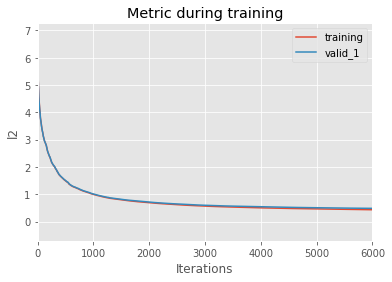

[100]	training's l2: 3.17346	valid_1's l2: 3.19681
[200]	training's l2: 2.43311	valid_1's l2: 2.45543
[300]	training's l2: 2.05348	valid_1's l2: 2.0761
[400]	training's l2: 1.69974	valid_1's l2: 1.72406
[500]	training's l2: 1.4896	valid_1's l2: 1.51213
[600]	training's l2: 1.3527	valid_1's l2: 1.37473
[700]	training's l2: 1.25782	valid_1's l2: 1.28016
[800]	training's l2: 1.1593	valid_1's l2: 1.18145
[900]	training's l2: 1.08456	valid_1's l2: 1.10682
[1000]	training's l2: 1.01542	valid_1's l2: 1.03814
[1100]	training's l2: 0.965623	valid_1's l2: 0.988075
[1200]	training's l2: 0.924607	valid_1's l2: 0.947386
[1300]	training's l2: 0.889631	valid_1's l2: 0.912639
[1400]	training's l2: 0.857235	valid_1's l2: 0.881067
[1500]	training's l2: 0.824101	valid_1's l2: 0.84858
[1600]	training's l2: 0.793335	valid_1's l2: 0.818244
[1700]	training's l2: 0.766908	valid_1's l2: 0.792148
[1800]	training's l2: 0.74403	valid_1's l2: 0.769509
[1900]	training's l2: 0.723982	valid_1's l2: 0.749595
[2000]	tr

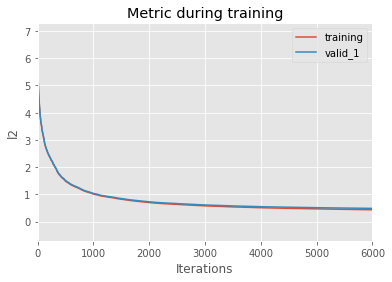

[100]	training's l2: 3.15261	valid_1's l2: 3.15469
[200]	training's l2: 2.48016	valid_1's l2: 2.48667
[300]	training's l2: 2.07986	valid_1's l2: 2.08582
[400]	training's l2: 1.78709	valid_1's l2: 1.794
[500]	training's l2: 1.58917	valid_1's l2: 1.59694
[600]	training's l2: 1.43472	valid_1's l2: 1.44254
[700]	training's l2: 1.33603	valid_1's l2: 1.34426
[800]	training's l2: 1.21706	valid_1's l2: 1.22632
[900]	training's l2: 1.13249	valid_1's l2: 1.14226
[1000]	training's l2: 1.06273	valid_1's l2: 1.07322
[1100]	training's l2: 1.00736	valid_1's l2: 1.01922
[1200]	training's l2: 0.965921	valid_1's l2: 0.979433
[1300]	training's l2: 0.923307	valid_1's l2: 0.937912
[1400]	training's l2: 0.88945	valid_1's l2: 0.905129
[1500]	training's l2: 0.844814	valid_1's l2: 0.862299
[1600]	training's l2: 0.808125	valid_1's l2: 0.826664
[1700]	training's l2: 0.776993	valid_1's l2: 0.796087
[1800]	training's l2: 0.748775	valid_1's l2: 0.768512
[1900]	training's l2: 0.727485	valid_1's l2: 0.748605
[2000]	t

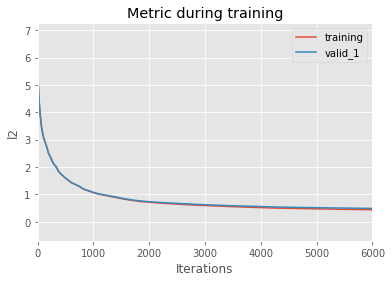

[100]	training's l2: 3.20073	valid_1's l2: 3.21179
[200]	training's l2: 2.46047	valid_1's l2: 2.47149
[300]	training's l2: 2.09963	valid_1's l2: 2.11171
[400]	training's l2: 1.80111	valid_1's l2: 1.81477
[500]	training's l2: 1.57906	valid_1's l2: 1.59303
[600]	training's l2: 1.42185	valid_1's l2: 1.43607
[700]	training's l2: 1.29333	valid_1's l2: 1.30898
[800]	training's l2: 1.19366	valid_1's l2: 1.20987
[900]	training's l2: 1.09503	valid_1's l2: 1.11187
[1000]	training's l2: 1.02411	valid_1's l2: 1.0419
[1100]	training's l2: 0.97103	valid_1's l2: 0.989593
[1200]	training's l2: 0.923211	valid_1's l2: 0.942665
[1300]	training's l2: 0.885278	valid_1's l2: 0.905902
[1400]	training's l2: 0.853639	valid_1's l2: 0.875274
[1500]	training's l2: 0.82642	valid_1's l2: 0.848934
[1600]	training's l2: 0.805089	valid_1's l2: 0.828702
[1700]	training's l2: 0.780234	valid_1's l2: 0.804589
[1800]	training's l2: 0.757532	valid_1's l2: 0.782748
[1900]	training's l2: 0.738443	valid_1's l2: 0.764391
[2000]

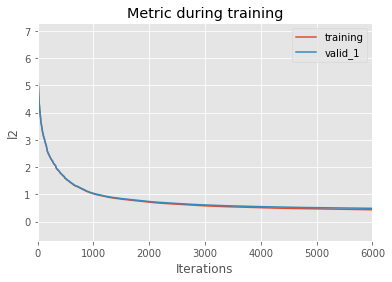

[100]	training's l2: 3.16034	valid_1's l2: 3.15485
[200]	training's l2: 2.41389	valid_1's l2: 2.41027
[300]	training's l2: 2.00042	valid_1's l2: 1.99914
[400]	training's l2: 1.69934	valid_1's l2: 1.70172
[500]	training's l2: 1.50749	valid_1's l2: 1.51195
[600]	training's l2: 1.35415	valid_1's l2: 1.35971
[700]	training's l2: 1.24242	valid_1's l2: 1.24982
[800]	training's l2: 1.13672	valid_1's l2: 1.146
[900]	training's l2: 1.05568	valid_1's l2: 1.0658
[1000]	training's l2: 0.995923	valid_1's l2: 1.00685
[1100]	training's l2: 0.94647	valid_1's l2: 0.958303
[1200]	training's l2: 0.894688	valid_1's l2: 0.908299
[1300]	training's l2: 0.849918	valid_1's l2: 0.865036
[1400]	training's l2: 0.818861	valid_1's l2: 0.835181
[1500]	training's l2: 0.795353	valid_1's l2: 0.813049
[1600]	training's l2: 0.769839	valid_1's l2: 0.78861
[1700]	training's l2: 0.745383	valid_1's l2: 0.764741
[1800]	training's l2: 0.726885	valid_1's l2: 0.74738
[1900]	training's l2: 0.710596	valid_1's l2: 0.73224
[2000]	tr

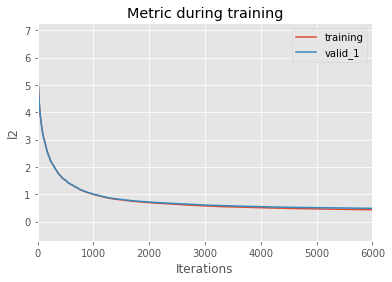

In [232]:
sub_lgb, oof_lgb,feature_importance_lgb = lgb_Regressor(train_df_remove3,
                                                        temp_remove3_lgb,
                                                        target_remove3)

[100]	training's l2: 3.21719	valid_1's l2: 3.20785
[200]	training's l2: 2.52127	valid_1's l2: 2.51341
[300]	training's l2: 2.10045	valid_1's l2: 2.09641
[400]	training's l2: 1.80947	valid_1's l2: 1.80855
[500]	training's l2: 1.60841	valid_1's l2: 1.60972
[600]	training's l2: 1.44806	valid_1's l2: 1.45132
[700]	training's l2: 1.33227	valid_1's l2: 1.33759
[800]	training's l2: 1.23294	valid_1's l2: 1.23968
[900]	training's l2: 1.15119	valid_1's l2: 1.15899
[1000]	training's l2: 1.06343	valid_1's l2: 1.0721
[1100]	training's l2: 1.00383	valid_1's l2: 1.0134
[1200]	training's l2: 0.957838	valid_1's l2: 0.968787
[1300]	training's l2: 0.917812	valid_1's l2: 0.929897
[1400]	training's l2: 0.879681	valid_1's l2: 0.892573
[1500]	training's l2: 0.843686	valid_1's l2: 0.857528
[1600]	training's l2: 0.813124	valid_1's l2: 0.82766
[1700]	training's l2: 0.788022	valid_1's l2: 0.803535
[1800]	training's l2: 0.763693	valid_1's l2: 0.779904
[1900]	training's l2: 0.745161	valid_1's l2: 0.76256
[2000]	tr

findfont: Font family ['NanumSquareR'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumSquareR'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumSquareR'] not found. Falling back to DejaVu Sans.


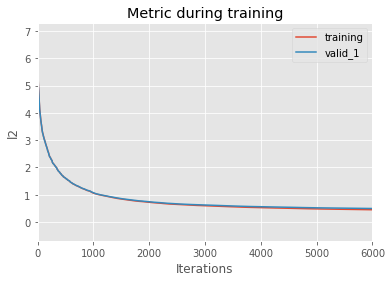

[100]	training's l2: 3.21092	valid_1's l2: 3.20928
[200]	training's l2: 2.45063	valid_1's l2: 2.45692
[300]	training's l2: 2.10702	valid_1's l2: 2.11577
[400]	training's l2: 1.77978	valid_1's l2: 1.78992
[500]	training's l2: 1.55225	valid_1's l2: 1.56403
[600]	training's l2: 1.42528	valid_1's l2: 1.43843
[700]	training's l2: 1.32373	valid_1's l2: 1.33778
[800]	training's l2: 1.21502	valid_1's l2: 1.23002
[900]	training's l2: 1.13219	valid_1's l2: 1.14803
[1000]	training's l2: 1.0622	valid_1's l2: 1.07857
[1100]	training's l2: 1.00888	valid_1's l2: 1.02565
[1200]	training's l2: 0.952092	valid_1's l2: 0.969476
[1300]	training's l2: 0.912123	valid_1's l2: 0.93037
[1400]	training's l2: 0.876559	valid_1's l2: 0.894778
[1500]	training's l2: 0.844223	valid_1's l2: 0.863327
[1600]	training's l2: 0.816612	valid_1's l2: 0.836238
[1700]	training's l2: 0.789755	valid_1's l2: 0.809979
[1800]	training's l2: 0.768984	valid_1's l2: 0.78977
[1900]	training's l2: 0.750234	valid_1's l2: 0.771779
[2000]	t

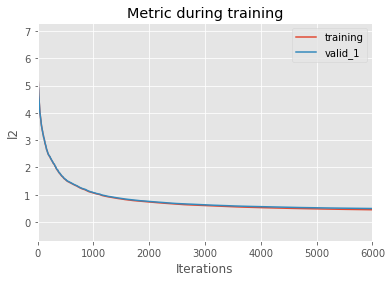

[100]	training's l2: 3.23951	valid_1's l2: 3.24772
[200]	training's l2: 2.53905	valid_1's l2: 2.55164
[300]	training's l2: 2.12028	valid_1's l2: 2.13638
[400]	training's l2: 1.84117	valid_1's l2: 1.85945
[500]	training's l2: 1.60953	valid_1's l2: 1.6299
[600]	training's l2: 1.44485	valid_1's l2: 1.46729
[700]	training's l2: 1.33886	valid_1's l2: 1.36153
[800]	training's l2: 1.22997	valid_1's l2: 1.25331
[900]	training's l2: 1.12958	valid_1's l2: 1.15372
[1000]	training's l2: 1.06254	valid_1's l2: 1.08714
[1100]	training's l2: 0.999275	valid_1's l2: 1.02447
[1200]	training's l2: 0.955412	valid_1's l2: 0.981122
[1300]	training's l2: 0.917841	valid_1's l2: 0.943799
[1400]	training's l2: 0.885458	valid_1's l2: 0.911634
[1500]	training's l2: 0.853331	valid_1's l2: 0.879215
[1600]	training's l2: 0.823516	valid_1's l2: 0.849671
[1700]	training's l2: 0.796521	valid_1's l2: 0.82304
[1800]	training's l2: 0.772018	valid_1's l2: 0.798501
[1900]	training's l2: 0.749702	valid_1's l2: 0.776384
[2000]

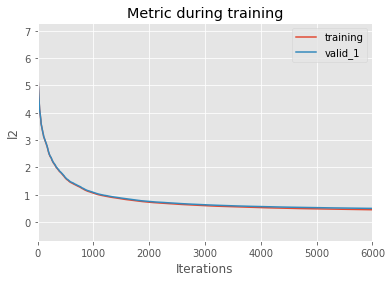

[100]	training's l2: 3.20359	valid_1's l2: 3.21102
[200]	training's l2: 2.44734	valid_1's l2: 2.45379
[300]	training's l2: 2.01818	valid_1's l2: 2.02527
[400]	training's l2: 1.78468	valid_1's l2: 1.79295
[500]	training's l2: 1.57269	valid_1's l2: 1.58172
[600]	training's l2: 1.46094	valid_1's l2: 1.47101
[700]	training's l2: 1.34534	valid_1's l2: 1.356
[800]	training's l2: 1.25444	valid_1's l2: 1.2662
[900]	training's l2: 1.17505	valid_1's l2: 1.1879
[1000]	training's l2: 1.10167	valid_1's l2: 1.1153
[1100]	training's l2: 1.03033	valid_1's l2: 1.0448
[1200]	training's l2: 0.975717	valid_1's l2: 0.990452
[1300]	training's l2: 0.926839	valid_1's l2: 0.942747
[1400]	training's l2: 0.890846	valid_1's l2: 0.907584
[1500]	training's l2: 0.85699	valid_1's l2: 0.87497
[1600]	training's l2: 0.82629	valid_1's l2: 0.845149
[1700]	training's l2: 0.802455	valid_1's l2: 0.822266
[1800]	training's l2: 0.780221	valid_1's l2: 0.801008
[1900]	training's l2: 0.758275	valid_1's l2: 0.779572
[2000]	trainin

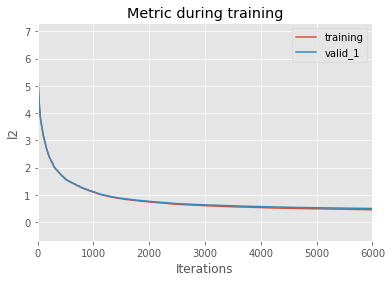

[100]	training's l2: 3.1828	valid_1's l2: 3.1984
[200]	training's l2: 2.51752	valid_1's l2: 2.5319
[300]	training's l2: 2.10796	valid_1's l2: 2.1226
[400]	training's l2: 1.88072	valid_1's l2: 1.89544
[500]	training's l2: 1.65224	valid_1's l2: 1.66663
[600]	training's l2: 1.45255	valid_1's l2: 1.46722
[700]	training's l2: 1.31335	valid_1's l2: 1.32795
[800]	training's l2: 1.20996	valid_1's l2: 1.22541
[900]	training's l2: 1.11377	valid_1's l2: 1.13061
[1000]	training's l2: 1.04232	valid_1's l2: 1.06016
[1100]	training's l2: 0.989754	valid_1's l2: 1.00787
[1200]	training's l2: 0.936846	valid_1's l2: 0.955638
[1300]	training's l2: 0.896231	valid_1's l2: 0.915706
[1400]	training's l2: 0.864277	valid_1's l2: 0.8845
[1500]	training's l2: 0.832317	valid_1's l2: 0.853432
[1600]	training's l2: 0.805078	valid_1's l2: 0.827274
[1700]	training's l2: 0.778702	valid_1's l2: 0.801134
[1800]	training's l2: 0.758317	valid_1's l2: 0.781501
[1900]	training's l2: 0.737322	valid_1's l2: 0.761068
[2000]	tra

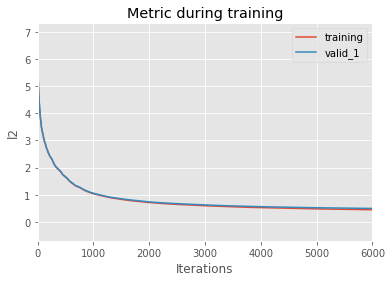

In [89]:
sub_lgb_real, oof_lgb_real,feature_importance_lgb_real = lgb_Regressor(train_df,
                                                        temp_real_lgb,
                                                        target)

[100]	training's l2: 3.14807	valid_1's l2: 3.1407
[200]	training's l2: 2.4577	valid_1's l2: 2.45595
[300]	training's l2: 2.00156	valid_1's l2: 2.00249
[400]	training's l2: 1.74868	valid_1's l2: 1.75098
[500]	training's l2: 1.52005	valid_1's l2: 1.52494
[600]	training's l2: 1.39001	valid_1's l2: 1.39734
[700]	training's l2: 1.27118	valid_1's l2: 1.27966
[800]	training's l2: 1.17969	valid_1's l2: 1.18933
[900]	training's l2: 1.1035	valid_1's l2: 1.1146
[1000]	training's l2: 1.03437	valid_1's l2: 1.04567
[1100]	training's l2: 0.972118	valid_1's l2: 0.984749
[1200]	training's l2: 0.922405	valid_1's l2: 0.935985
[1300]	training's l2: 0.881169	valid_1's l2: 0.895524
[1400]	training's l2: 0.849863	valid_1's l2: 0.865474
[1500]	training's l2: 0.821244	valid_1's l2: 0.837886
[1600]	training's l2: 0.795976	valid_1's l2: 0.813743
[1700]	training's l2: 0.77082	valid_1's l2: 0.789723
[1800]	training's l2: 0.74608	valid_1's l2: 0.766002
[1900]	training's l2: 0.729675	valid_1's l2: 0.750672
[2000]	tr

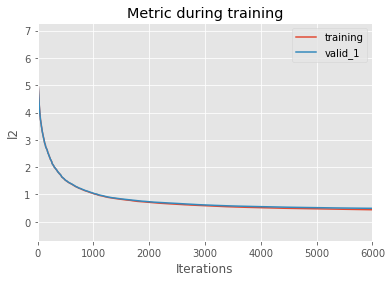

[100]	training's l2: 3.14774	valid_1's l2: 3.14857
[200]	training's l2: 2.4488	valid_1's l2: 2.45533
[300]	training's l2: 1.98354	valid_1's l2: 1.99339
[400]	training's l2: 1.72226	valid_1's l2: 1.73369
[500]	training's l2: 1.5493	valid_1's l2: 1.5624
[600]	training's l2: 1.40924	valid_1's l2: 1.42336
[700]	training's l2: 1.24349	valid_1's l2: 1.25834
[800]	training's l2: 1.13507	valid_1's l2: 1.15025
[900]	training's l2: 1.05737	valid_1's l2: 1.07342
[1000]	training's l2: 0.989355	valid_1's l2: 1.00619
[1100]	training's l2: 0.94182	valid_1's l2: 0.959376
[1200]	training's l2: 0.899494	valid_1's l2: 0.917546
[1300]	training's l2: 0.863139	valid_1's l2: 0.881477
[1400]	training's l2: 0.830801	valid_1's l2: 0.850315
[1500]	training's l2: 0.800618	valid_1's l2: 0.820744
[1600]	training's l2: 0.773842	valid_1's l2: 0.794377
[1700]	training's l2: 0.748528	valid_1's l2: 0.769727
[1800]	training's l2: 0.727828	valid_1's l2: 0.7498
[1900]	training's l2: 0.710468	valid_1's l2: 0.733349
[2000]	t

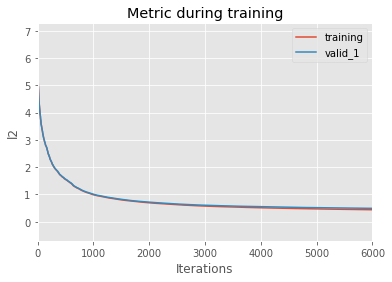

[100]	training's l2: 3.21951	valid_1's l2: 3.22559
[200]	training's l2: 2.52725	valid_1's l2: 2.5414
[300]	training's l2: 2.08248	valid_1's l2: 2.09978
[400]	training's l2: 1.704	valid_1's l2: 1.72255
[500]	training's l2: 1.52575	valid_1's l2: 1.54632
[600]	training's l2: 1.39512	valid_1's l2: 1.41657
[700]	training's l2: 1.27998	valid_1's l2: 1.30284
[800]	training's l2: 1.18912	valid_1's l2: 1.2133
[900]	training's l2: 1.11073	valid_1's l2: 1.13695
[1000]	training's l2: 1.04067	valid_1's l2: 1.0686
[1100]	training's l2: 0.977094	valid_1's l2: 1.00539
[1200]	training's l2: 0.927315	valid_1's l2: 0.956129
[1300]	training's l2: 0.885812	valid_1's l2: 0.91528
[1400]	training's l2: 0.845352	valid_1's l2: 0.874818
[1500]	training's l2: 0.814711	valid_1's l2: 0.845133
[1600]	training's l2: 0.790728	valid_1's l2: 0.821779
[1700]	training's l2: 0.763766	valid_1's l2: 0.795057
[1800]	training's l2: 0.740439	valid_1's l2: 0.771991
[1900]	training's l2: 0.716409	valid_1's l2: 0.748198
[2000]	tra

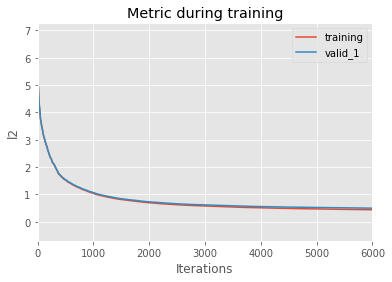

[100]	training's l2: 3.14764	valid_1's l2: 3.16144
[200]	training's l2: 2.3958	valid_1's l2: 2.40614
[300]	training's l2: 1.93058	valid_1's l2: 1.93969
[400]	training's l2: 1.68447	valid_1's l2: 1.69483
[500]	training's l2: 1.48197	valid_1's l2: 1.49326
[600]	training's l2: 1.34904	valid_1's l2: 1.36083
[700]	training's l2: 1.26106	valid_1's l2: 1.27388
[800]	training's l2: 1.18261	valid_1's l2: 1.19662
[900]	training's l2: 1.10607	valid_1's l2: 1.12079
[1000]	training's l2: 1.03485	valid_1's l2: 1.0503
[1100]	training's l2: 0.981595	valid_1's l2: 0.997885
[1200]	training's l2: 0.942579	valid_1's l2: 0.959777
[1300]	training's l2: 0.900511	valid_1's l2: 0.918707
[1400]	training's l2: 0.864825	valid_1's l2: 0.884446
[1500]	training's l2: 0.834145	valid_1's l2: 0.854783
[1600]	training's l2: 0.807702	valid_1's l2: 0.829717
[1700]	training's l2: 0.780636	valid_1's l2: 0.80332
[1800]	training's l2: 0.754353	valid_1's l2: 0.777874
[1900]	training's l2: 0.727716	valid_1's l2: 0.752139
[2000]

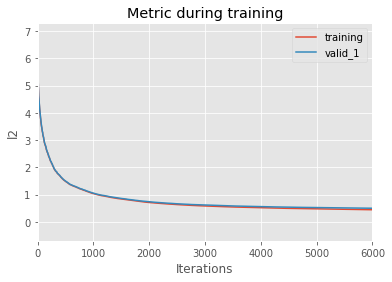

[100]	training's l2: 3.12607	valid_1's l2: 3.14035
[200]	training's l2: 2.35648	valid_1's l2: 2.36869
[300]	training's l2: 1.92563	valid_1's l2: 1.93835
[400]	training's l2: 1.67915	valid_1's l2: 1.69272
[500]	training's l2: 1.49017	valid_1's l2: 1.5054
[600]	training's l2: 1.34256	valid_1's l2: 1.35906
[700]	training's l2: 1.21609	valid_1's l2: 1.23422
[800]	training's l2: 1.13199	valid_1's l2: 1.1505
[900]	training's l2: 1.0541	valid_1's l2: 1.07301
[1000]	training's l2: 1.00137	valid_1's l2: 1.02101
[1100]	training's l2: 0.944083	valid_1's l2: 0.963918
[1200]	training's l2: 0.899057	valid_1's l2: 0.919762
[1300]	training's l2: 0.863344	valid_1's l2: 0.885155
[1400]	training's l2: 0.827921	valid_1's l2: 0.850481
[1500]	training's l2: 0.797391	valid_1's l2: 0.820366
[1600]	training's l2: 0.765621	valid_1's l2: 0.788855
[1700]	training's l2: 0.742274	valid_1's l2: 0.766083
[1800]	training's l2: 0.723868	valid_1's l2: 0.748568
[1900]	training's l2: 0.704333	valid_1's l2: 0.73006
[2000]	

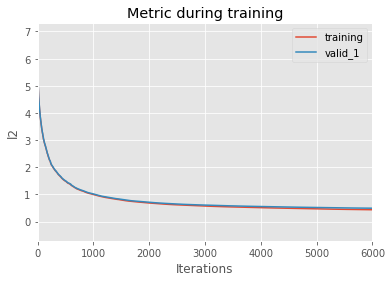

In [234]:
# 인구통계 합친 버전
sub_lgb_real, oof_lgb_real,feature_importance_lgb_real = lgb_Regressor(train_df,
                                                        temp_real_lgb3,
                                                        target)

[100]	training's l2: 3.19472	valid_1's l2: 3.19284
[200]	training's l2: 2.48784	valid_1's l2: 2.48736
[300]	training's l2: 2.04444	valid_1's l2: 2.04548
[400]	training's l2: 1.7834	valid_1's l2: 1.78704
[500]	training's l2: 1.60188	valid_1's l2: 1.60612
[600]	training's l2: 1.45505	valid_1's l2: 1.45911
[700]	training's l2: 1.33847	valid_1's l2: 1.34408
[800]	training's l2: 1.241	valid_1's l2: 1.24745
[900]	training's l2: 1.16557	valid_1's l2: 1.17353
[1000]	training's l2: 1.08193	valid_1's l2: 1.09171
[1100]	training's l2: 1.01708	valid_1's l2: 1.02843
[1200]	training's l2: 0.968392	valid_1's l2: 0.980378
[1300]	training's l2: 0.925828	valid_1's l2: 0.939192
[1400]	training's l2: 0.889852	valid_1's l2: 0.903823
[1500]	training's l2: 0.857746	valid_1's l2: 0.872421
[1600]	training's l2: 0.827232	valid_1's l2: 0.842863
[1700]	training's l2: 0.802846	valid_1's l2: 0.81916
[1800]	training's l2: 0.781199	valid_1's l2: 0.79878
[1900]	training's l2: 0.758968	valid_1's l2: 0.777166
[2000]	tra

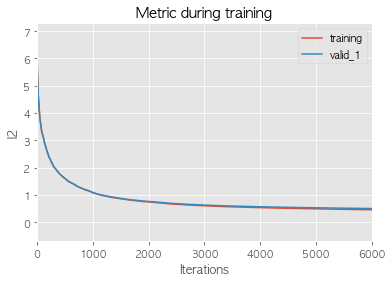

[100]	training's l2: 3.24804	valid_1's l2: 3.24234
[200]	training's l2: 2.61583	valid_1's l2: 2.61425
[300]	training's l2: 2.17027	valid_1's l2: 2.1717
[400]	training's l2: 1.82694	valid_1's l2: 1.8323
[500]	training's l2: 1.61489	valid_1's l2: 1.62282
[600]	training's l2: 1.42678	valid_1's l2: 1.4368
[700]	training's l2: 1.31119	valid_1's l2: 1.3232
[800]	training's l2: 1.22205	valid_1's l2: 1.23445
[900]	training's l2: 1.13368	valid_1's l2: 1.14704
[1000]	training's l2: 1.07636	valid_1's l2: 1.09125
[1100]	training's l2: 1.02294	valid_1's l2: 1.03837
[1200]	training's l2: 0.977264	valid_1's l2: 0.99344
[1300]	training's l2: 0.929296	valid_1's l2: 0.945883
[1400]	training's l2: 0.896285	valid_1's l2: 0.913781
[1500]	training's l2: 0.86402	valid_1's l2: 0.882328
[1600]	training's l2: 0.830921	valid_1's l2: 0.849752
[1700]	training's l2: 0.804869	valid_1's l2: 0.824618
[1800]	training's l2: 0.780473	valid_1's l2: 0.801187
[1900]	training's l2: 0.758203	valid_1's l2: 0.779049
[2000]	trai

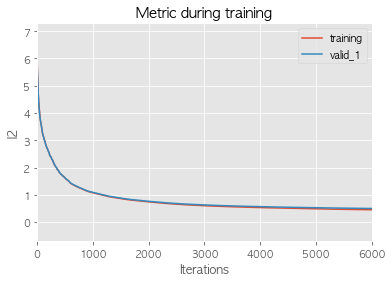

[100]	training's l2: 3.20136	valid_1's l2: 3.22929
[200]	training's l2: 2.52502	valid_1's l2: 2.54742
[300]	training's l2: 2.09635	valid_1's l2: 2.1162
[400]	training's l2: 1.83719	valid_1's l2: 1.85458
[500]	training's l2: 1.60496	valid_1's l2: 1.62121
[600]	training's l2: 1.42404	valid_1's l2: 1.43888
[700]	training's l2: 1.29661	valid_1's l2: 1.3118
[800]	training's l2: 1.20213	valid_1's l2: 1.2172
[900]	training's l2: 1.12311	valid_1's l2: 1.13778
[1000]	training's l2: 1.05603	valid_1's l2: 1.07072
[1100]	training's l2: 0.996984	valid_1's l2: 1.01168
[1200]	training's l2: 0.95852	valid_1's l2: 0.973942
[1300]	training's l2: 0.913221	valid_1's l2: 0.929287
[1400]	training's l2: 0.874097	valid_1's l2: 0.890637
[1500]	training's l2: 0.842441	valid_1's l2: 0.859498
[1600]	training's l2: 0.815799	valid_1's l2: 0.833319
[1700]	training's l2: 0.792125	valid_1's l2: 0.81027
[1800]	training's l2: 0.771169	valid_1's l2: 0.789704
[1900]	training's l2: 0.751447	valid_1's l2: 0.770618
[2000]	tr

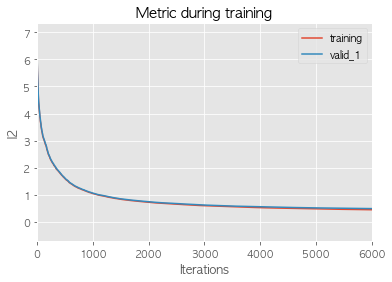

[100]	training's l2: 3.21929	valid_1's l2: 3.21438
[200]	training's l2: 2.5068	valid_1's l2: 2.50642
[300]	training's l2: 2.10114	valid_1's l2: 2.10559
[400]	training's l2: 1.87055	valid_1's l2: 1.87571
[500]	training's l2: 1.65031	valid_1's l2: 1.65695
[600]	training's l2: 1.48901	valid_1's l2: 1.49733
[700]	training's l2: 1.34781	valid_1's l2: 1.35779
[800]	training's l2: 1.2448	valid_1's l2: 1.25626
[900]	training's l2: 1.1763	valid_1's l2: 1.18912
[1000]	training's l2: 1.11678	valid_1's l2: 1.1306
[1100]	training's l2: 1.06817	valid_1's l2: 1.08283
[1200]	training's l2: 1.00191	valid_1's l2: 1.0174
[1300]	training's l2: 0.947266	valid_1's l2: 0.963123
[1400]	training's l2: 0.902616	valid_1's l2: 0.919352
[1500]	training's l2: 0.857882	valid_1's l2: 0.875053
[1600]	training's l2: 0.826734	valid_1's l2: 0.845058
[1700]	training's l2: 0.797626	valid_1's l2: 0.817117
[1800]	training's l2: 0.775119	valid_1's l2: 0.79535
[1900]	training's l2: 0.756593	valid_1's l2: 0.777712
[2000]	traini

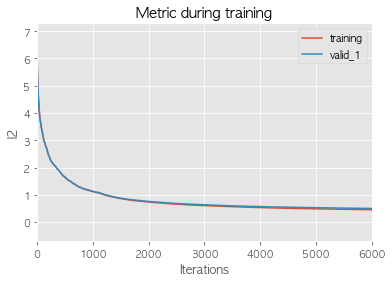

[100]	training's l2: 3.2139	valid_1's l2: 3.22269
[200]	training's l2: 2.48705	valid_1's l2: 2.49937
[300]	training's l2: 2.00003	valid_1's l2: 2.01345
[400]	training's l2: 1.76213	valid_1's l2: 1.77576
[500]	training's l2: 1.54668	valid_1's l2: 1.5613
[600]	training's l2: 1.41093	valid_1's l2: 1.4257
[700]	training's l2: 1.29781	valid_1's l2: 1.31341
[800]	training's l2: 1.20087	valid_1's l2: 1.21732
[900]	training's l2: 1.11547	valid_1's l2: 1.13244
[1000]	training's l2: 1.04588	valid_1's l2: 1.06315
[1100]	training's l2: 0.989661	valid_1's l2: 1.00786
[1200]	training's l2: 0.942394	valid_1's l2: 0.961741
[1300]	training's l2: 0.900938	valid_1's l2: 0.920529
[1400]	training's l2: 0.866297	valid_1's l2: 0.88651
[1500]	training's l2: 0.83759	valid_1's l2: 0.858557
[1600]	training's l2: 0.814977	valid_1's l2: 0.836825
[1700]	training's l2: 0.790497	valid_1's l2: 0.81316
[1800]	training's l2: 0.767165	valid_1's l2: 0.790312
[1900]	training's l2: 0.750284	valid_1's l2: 0.774157
[2000]	tra

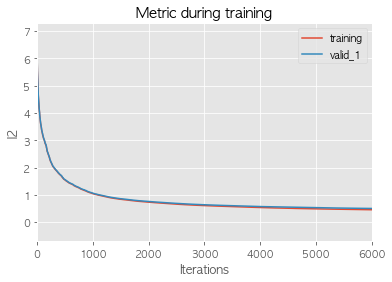

In [657]:
sub_lgb_real, oof_lgb_real,feature_importance_lgb_real = lgb_Regressor(train_df,
                                                        temp_real_lgb,
                                                        target)

# ***Catboost***

In [79]:
# 학습 : 교차검증
# LGBM 예측 (실 예측 or 검증셋 예측)
def cat_Regressor(train_df, temp, target):
    
    folds = KFold(n_splits=5,random_state = 1001)

    sub_predict = np.zeros(temp.shape[0])
    oof_predict = np.zeros(train_df.shape[0])
    feature_importance_df = pd.DataFrame()

    for folds_, (train_idx,valid_idx) in enumerate(folds.split(train_df,target)):
        train_x, train_y = train_df.iloc[train_idx], target.iloc[train_idx]
        valid_x, valid_y = train_df.iloc[valid_idx], target.iloc[valid_idx]
        
        '''
        params = {
            'learning_rate' : 0.05,
            'boosting_type': 'gbdt',
            'objective': 'tweedie',
            'tweedie_variance_power': 1.1,
            'metric': 'rmse',
            'sub_row' : 0.75,
            'lambda_l2' : 0.1
        }'''
        
        # 기존 파라미터 n_estimators = 5000, eval_metric = rmsle(평가 metric로 있는건가...) 이 상태 그대로
        # 학습량 5000까지 늘려서 검증해봐야겠다 근데 성능이 안좋을 것 같은게 처음에 완전 쌩 디폴트 파라미터로 제출한
        # lgbm모델의 성능이 더 좋았음
        reg = cb.CatBoostRegressor(random_state=0,n_estimators = 6000)
        
        reg.fit(train_x, train_y, eval_set = [(train_x, train_y), (valid_x, valid_y)], verbose= 100)
        
        #cat.plot_metric(reg)
        #plt.show()
        
        oof_predict[valid_idx] = reg.predict(valid_x)
        sub_predict += reg.predict(temp) / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = train_df.columns
        fold_importance_df["importance"] = reg.feature_importances_
        fold_importance_df["fold"] = folds_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
    feature_importance_fin = feature_importance_df[["feature", "importance"]].\
                groupby("feature").mean().sort_values(by="importance", ascending=False)
    
    
    return sub_predict, oof_predict, feature_importance_fin

In [80]:
sub_cat_real, oof_cat_real,feature_importance_cat_real = cat_Regressor(train_df,
                                                        temp_real_cat,
                                                        target)

Learning rate set to 0.053947
0:	learn: 2.4961567	test: 2.4961567	test1: 2.4910976	best: 2.4910976 (0)	total: 60.6ms	remaining: 6m 3s
100:	learn: 2.1418852	test: 2.1418852	test1: 2.1388395	best: 2.1388395 (100)	total: 4.5s	remaining: 4m 22s
200:	learn: 2.0017611	test: 2.0017611	test1: 1.9991294	best: 1.9991294 (200)	total: 8.92s	remaining: 4m 17s
300:	learn: 1.9020620	test: 1.9020620	test1: 1.8995985	best: 1.8995985 (300)	total: 13.5s	remaining: 4m 14s
400:	learn: 1.8236784	test: 1.8236784	test1: 1.8213693	best: 1.8213693 (400)	total: 17.9s	remaining: 4m 10s
500:	learn: 1.7619408	test: 1.7619408	test1: 1.7593225	best: 1.7593225 (500)	total: 22.4s	remaining: 4m 6s
600:	learn: 1.7032896	test: 1.7032896	test1: 1.7002808	best: 1.7002808 (600)	total: 26.9s	remaining: 4m 1s
700:	learn: 1.6560062	test: 1.6560062	test1: 1.6529902	best: 1.6529902 (700)	total: 31.4s	remaining: 3m 57s
800:	learn: 1.6053605	test: 1.6053605	test1: 1.6021906	best: 1.6021906 (800)	total: 35.9s	remaining: 3m 52s
900:	

1300:	learn: 1.4584143	test: 1.4584143	test1: 1.4613579	best: 1.4613579 (1300)	total: 1m	remaining: 3m 37s
1400:	learn: 1.4339128	test: 1.4339128	test1: 1.4368986	best: 1.4368986 (1400)	total: 1m 4s	remaining: 3m 33s
1500:	learn: 1.4100196	test: 1.4100196	test1: 1.4129974	best: 1.4129974 (1500)	total: 1m 9s	remaining: 3m 28s
1600:	learn: 1.3887278	test: 1.3887278	test1: 1.3919149	best: 1.3919149 (1600)	total: 1m 14s	remaining: 3m 24s
1700:	learn: 1.3711955	test: 1.3711955	test1: 1.3745638	best: 1.3745638 (1700)	total: 1m 19s	remaining: 3m 19s
1800:	learn: 1.3533170	test: 1.3533170	test1: 1.3567392	best: 1.3567392 (1800)	total: 1m 23s	remaining: 3m 15s
1900:	learn: 1.3379643	test: 1.3379643	test1: 1.3415443	best: 1.3415443 (1900)	total: 1m 28s	remaining: 3m 10s
2000:	learn: 1.3222843	test: 1.3222843	test1: 1.3259903	best: 1.3259903 (2000)	total: 1m 32s	remaining: 3m 5s
2100:	learn: 1.3089274	test: 1.3089274	test1: 1.3127778	best: 1.3127778 (2100)	total: 1m 37s	remaining: 3m 1s
2200:	lea

2600:	learn: 1.2429249	test: 1.2429249	test1: 1.2499835	best: 1.2499835 (2600)	total: 1m 54s	remaining: 2m 28s
2700:	learn: 1.2314452	test: 1.2314452	test1: 1.2387339	best: 1.2387339 (2700)	total: 1m 58s	remaining: 2m 24s
2800:	learn: 1.2216951	test: 1.2216951	test1: 1.2289786	best: 1.2289786 (2800)	total: 2m 2s	remaining: 2m 20s
2900:	learn: 1.2109550	test: 1.2109550	test1: 1.2183892	best: 1.2183892 (2900)	total: 2m 7s	remaining: 2m 15s
3000:	learn: 1.2015587	test: 1.2015587	test1: 1.2091174	best: 1.2091174 (3000)	total: 2m 11s	remaining: 2m 11s
3100:	learn: 1.1927937	test: 1.1927937	test1: 1.2005262	best: 1.2005262 (3100)	total: 2m 16s	remaining: 2m 7s
3200:	learn: 1.1847536	test: 1.1847536	test1: 1.1926054	best: 1.1926054 (3200)	total: 2m 20s	remaining: 2m 2s
3300:	learn: 1.1767621	test: 1.1767621	test1: 1.1847372	best: 1.1847372 (3300)	total: 2m 25s	remaining: 1m 58s
3400:	learn: 1.1697191	test: 1.1697191	test1: 1.1777721	best: 1.1777721 (3400)	total: 2m 30s	remaining: 1m 54s
3500:

3900:	learn: 1.1322294	test: 1.1322294	test1: 1.1351444	best: 1.1351444 (3900)	total: 3m 14s	remaining: 1m 44s
4000:	learn: 1.1256911	test: 1.1256911	test1: 1.1287165	best: 1.1287165 (4000)	total: 3m 19s	remaining: 1m 39s
4100:	learn: 1.1193931	test: 1.1193931	test1: 1.1225112	best: 1.1225112 (4100)	total: 3m 24s	remaining: 1m 34s
4200:	learn: 1.1131854	test: 1.1131854	test1: 1.1164329	best: 1.1164329 (4200)	total: 3m 29s	remaining: 1m 29s
4300:	learn: 1.1070817	test: 1.1070817	test1: 1.1103388	best: 1.1103388 (4300)	total: 3m 34s	remaining: 1m 24s
4400:	learn: 1.1007501	test: 1.1007501	test1: 1.1041250	best: 1.1041250 (4400)	total: 3m 39s	remaining: 1m 19s
4500:	learn: 1.0949338	test: 1.0949338	test1: 1.0984457	best: 1.0984457 (4500)	total: 3m 44s	remaining: 1m 14s
4600:	learn: 1.0894531	test: 1.0894531	test1: 1.0930115	best: 1.0930115 (4600)	total: 3m 49s	remaining: 1m 9s
4700:	learn: 1.0839773	test: 1.0839773	test1: 1.0875887	best: 1.0875887 (4700)	total: 3m 54s	remaining: 1m 4s
480

5200:	learn: 1.0584704	test: 1.0584704	test1: 1.0653536	best: 1.0653536 (5200)	total: 4m 10s	remaining: 38.4s
5300:	learn: 1.0536943	test: 1.0536943	test1: 1.0606812	best: 1.0606812 (5300)	total: 4m 14s	remaining: 33.6s
5400:	learn: 1.0492660	test: 1.0492660	test1: 1.0563553	best: 1.0563553 (5400)	total: 4m 19s	remaining: 28.8s
5500:	learn: 1.0449233	test: 1.0449233	test1: 1.0520151	best: 1.0520151 (5500)	total: 4m 24s	remaining: 24s
5600:	learn: 1.0404907	test: 1.0404907	test1: 1.0477487	best: 1.0477487 (5600)	total: 4m 28s	remaining: 19.2s
5700:	learn: 1.0359238	test: 1.0359238	test1: 1.0432125	best: 1.0432125 (5700)	total: 4m 33s	remaining: 14.3s
5800:	learn: 1.0320544	test: 1.0320544	test1: 1.0393860	best: 1.0393860 (5800)	total: 4m 38s	remaining: 9.55s
5900:	learn: 1.0279232	test: 1.0279232	test1: 1.0353267	best: 1.0353267 (5900)	total: 4m 43s	remaining: 4.75s
5999:	learn: 1.0240330	test: 1.0240330	test1: 1.0315589	best: 1.0315589 (5999)	total: 4m 47s	remaining: 0us

bestTest = 1.

# ***XGB***

In [86]:
# 학습 : 교차검증
# LGBM 예측 (실 예측 or 검증셋 예측)
def xgb_Regressor(train_df, temp, target):
    
    folds = KFold(n_splits=5,random_state = 1001)

    sub_predict = np.zeros(temp.shape[0])
    oof_predict = np.zeros(train_df.shape[0])
    feature_importance_df = pd.DataFrame()

    for folds_, (train_idx,valid_idx) in enumerate(folds.split(train_df,target)):
        train_x, train_y = train_df.iloc[train_idx], target.iloc[train_idx]
        valid_x, valid_y = train_df.iloc[valid_idx], target.iloc[valid_idx]
        
        '''
        params = {
            'learning_rate' : 0.05,
            'boosting_type': 'gbdt',
            'objective': 'tweedie',
            'tweedie_variance_power': 1.1,
            'metric': 'rmse',
            'sub_row' : 0.75,
            'lambda_l2' : 0.1
        }'''
        
        # 기존 파라미터 n_estimators = 5000, eval_metric = rmsle(평가 metric로 있는건가...) 이 상태 그대로
        # 학습량 5000까지 늘려서 검증해봐야겠다 근데 성능이 안좋을 것 같은게 처음에 완전 쌩 디폴트 파라미터로 제출한
        # lgbm모델의 성능이 더 좋았음
        reg = xgb.XGBRegressor(random_state=0,n_estimators = 6000)
        
        reg.fit(train_x, train_y, eval_set = [(train_x, train_y), (valid_x, valid_y)], 
                   eval_metric='rmsle', verbose= 100)
        
        #lgb.plot_metric(reg)
        #plt.show()
        
        oof_predict[valid_idx] = reg.predict(valid_x)
        sub_predict += reg.predict(temp) / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = train_df.columns
        fold_importance_df["importance"] = reg.feature_importances_
        fold_importance_df["fold"] = folds_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
    feature_importance_fin = feature_importance_df[["feature", "importance"]].\
                groupby("feature").mean().sort_values(by="importance", ascending=False)
    
    
    return sub_predict, oof_predict, feature_importance_fin

In [87]:
sub_xgb_real, oof_xgb_real,feature_importance_xgb_real = xgb_Regressor(train_df,
                                                        temp_real_xgb,
                                                        target)

[0]	validation_0-rmsle:0.99701	validation_1-rmsle:0.99742
[100]	validation_0-rmsle:0.09417	validation_1-rmsle:0.09419
[200]	validation_0-rmsle:0.07999	validation_1-rmsle:0.08025
[300]	validation_0-rmsle:0.07167	validation_1-rmsle:0.07221
[400]	validation_0-rmsle:0.06730	validation_1-rmsle:0.06802
[500]	validation_0-rmsle:0.06396	validation_1-rmsle:0.06480
[600]	validation_0-rmsle:0.06163	validation_1-rmsle:0.06259
[700]	validation_0-rmsle:0.05969	validation_1-rmsle:0.06080
[800]	validation_0-rmsle:0.05834	validation_1-rmsle:0.05957
[900]	validation_0-rmsle:0.05723	validation_1-rmsle:0.05860
[1000]	validation_0-rmsle:0.05611	validation_1-rmsle:0.05760
[1100]	validation_0-rmsle:0.05525	validation_1-rmsle:0.05686
[1200]	validation_0-rmsle:0.05446	validation_1-rmsle:0.05620
[1300]	validation_0-rmsle:0.05384	validation_1-rmsle:0.05573
[1400]	validation_0-rmsle:0.05323	validation_1-rmsle:0.05523
[1500]	validation_0-rmsle:0.05265	validation_1-rmsle:0.05475
[1600]	validation_0-rmsle:0.05218	va

[1300]	validation_0-rmsle:0.05370	validation_1-rmsle:0.05601
[1400]	validation_0-rmsle:0.05310	validation_1-rmsle:0.05551
[1500]	validation_0-rmsle:0.05258	validation_1-rmsle:0.05509
[1600]	validation_0-rmsle:0.05211	validation_1-rmsle:0.05471
[1700]	validation_0-rmsle:0.05169	validation_1-rmsle:0.05440
[1800]	validation_0-rmsle:0.05128	validation_1-rmsle:0.05408
[1900]	validation_0-rmsle:0.05094	validation_1-rmsle:0.05382
[2000]	validation_0-rmsle:0.05056	validation_1-rmsle:0.05352
[2100]	validation_0-rmsle:0.05024	validation_1-rmsle:0.05326
[2200]	validation_0-rmsle:0.04993	validation_1-rmsle:0.05304
[2300]	validation_0-rmsle:0.04967	validation_1-rmsle:0.05286
[2400]	validation_0-rmsle:0.04940	validation_1-rmsle:0.05266
[2500]	validation_0-rmsle:0.04912	validation_1-rmsle:0.05246
[2600]	validation_0-rmsle:0.04889	validation_1-rmsle:0.05231
[2700]	validation_0-rmsle:0.04865	validation_1-rmsle:0.05214
[2800]	validation_0-rmsle:0.04845	validation_1-rmsle:0.05202
[2900]	validation_0-rmsl

[2600]	validation_0-rmsle:0.04896	validation_1-rmsle:0.05214
[2700]	validation_0-rmsle:0.04874	validation_1-rmsle:0.05199
[2800]	validation_0-rmsle:0.04854	validation_1-rmsle:0.05186
[2900]	validation_0-rmsle:0.04834	validation_1-rmsle:0.05173
[3000]	validation_0-rmsle:0.04816	validation_1-rmsle:0.05160
[3100]	validation_0-rmsle:0.04796	validation_1-rmsle:0.05146
[3200]	validation_0-rmsle:0.04778	validation_1-rmsle:0.05134
[3300]	validation_0-rmsle:0.04760	validation_1-rmsle:0.05122
[3400]	validation_0-rmsle:0.04743	validation_1-rmsle:0.05111
[3500]	validation_0-rmsle:0.04727	validation_1-rmsle:0.05100
[3600]	validation_0-rmsle:0.04712	validation_1-rmsle:0.05092
[3700]	validation_0-rmsle:0.04697	validation_1-rmsle:0.05083
[3800]	validation_0-rmsle:0.04683	validation_1-rmsle:0.05075
[3900]	validation_0-rmsle:0.04670	validation_1-rmsle:0.05066
[4000]	validation_0-rmsle:0.04656	validation_1-rmsle:0.05057
[4100]	validation_0-rmsle:0.04643	validation_1-rmsle:0.05049
[4200]	validation_0-rmsl

# ***변수 중요도***

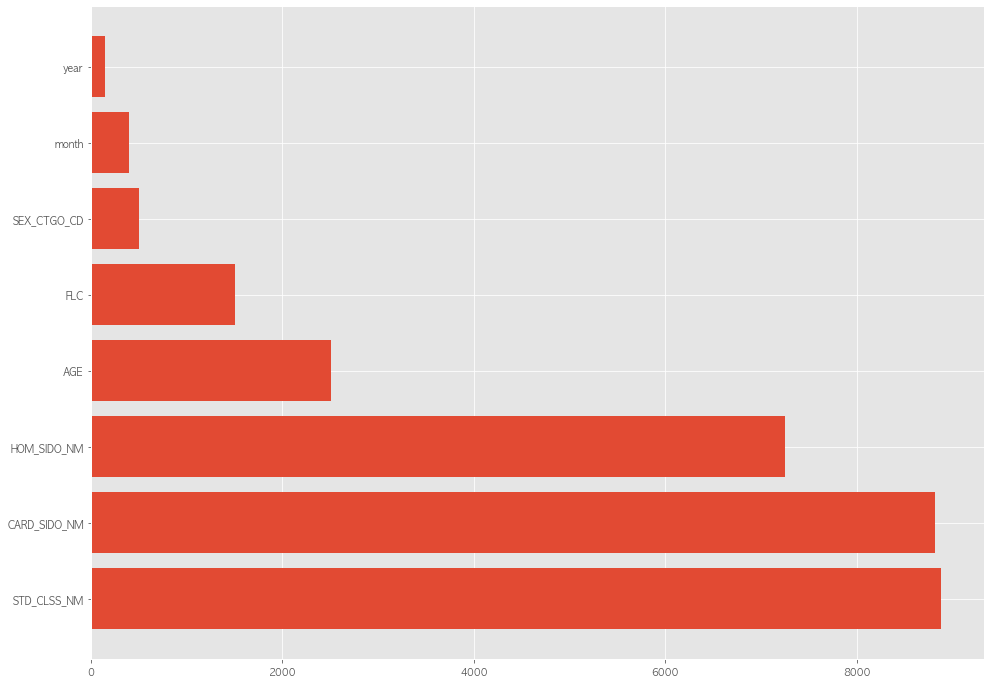

In [26]:
plt.figure(figsize = (16,12))
plt.barh(feature_importance_lgb_real.index,feature_importance_lgb_real['importance'])
plt.yticks(fontweight = 'bold')
plt.show()

findfont: Font family ['NanumSquareR'] not found. Falling back to DejaVu Sans.


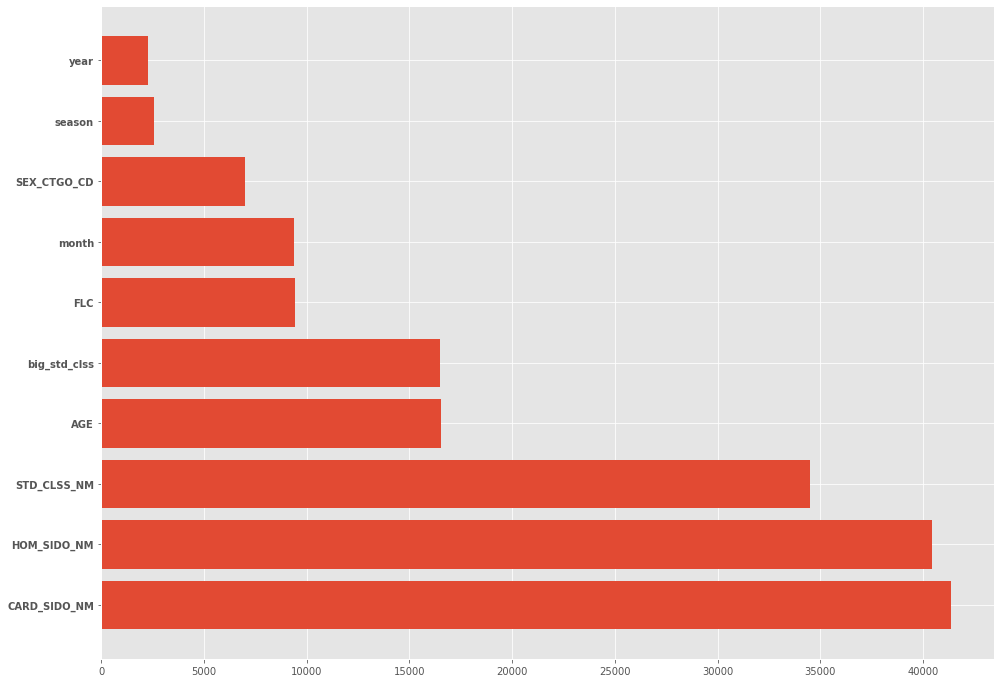

In [278]:
plt.figure(figsize = (16,12))
plt.barh(feature_importance_lgb_real.index,feature_importance_lgb_real['importance'])
plt.yticks(fontweight = 'bold')
plt.show()

# ***제출 및 검증 코드***

In [97]:
# 로컬에서 validation으로 검증할 것인지 or 실제 제출 파일을 만들 것인지?
def local_valid_function(sub,temp_df,sub_df,version_num,encoders,real_train = False):
    if real_train == False:
        pred = np.expm1(sub)
        temp_df['AMT'] = np.round(pred, 0)
        temp_df2 = temp_df
        temp_df['REG_YYMM'] = temp_df['year']*100 + temp_df['month']
        temp_df = temp_df[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
        temp_df = temp_df.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

        # 디코딩 
        temp_df['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp_df['CARD_SIDO_NM'])
        temp_df['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp_df['STD_CLSS_NM'])

        test_valid3 = sub_df.drop(['AMT'], axis=1)
        test_valid3 = test_valid3.merge(temp_df, left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
        test_valid3.index.name = 'id'
        #test_validation.drop(columns = 'id',inplace = True)
        #sub.to_csv('제출폴더/submission_version1.csv', encoding='utf-8-sig')
        #sub.head()
    
        return temp_df2, test_valid3
    
    elif real_train == True:
        
        pred = np.expm1(sub)
        temp_df['AMT'] = np.round(pred, 0)
        temp_df['REG_YYMM'] = temp_df['year']*100 + temp_df['month']
        temp_df = temp_df[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
        temp_df = temp_df.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

        # 디코딩 
        temp_df['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp_df['CARD_SIDO_NM'])
        temp_df['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp_df['STD_CLSS_NM'])

        sub = sub_df.drop(['AMT'], axis=1)
        sub = sub.merge(temp_df, left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
        sub.index.name = 'id'
        try:
            sub.drop(columns = 'id',inplace = True)
        except:
            pass
        #sub.to_csv('제출폴더/submission_version{}.csv'.format(version_num), encoding='utf-8-sig')
        #sub.head()
        
        return sub 

In [98]:
#올해 3월까지로 예측한 4월
sub_lgb = local_valid_function(sub_lgb_real,temp_real_lgb,sub_lgb,7,encoder_real,True)

In [ ]:
sub_lgb_used = sub_lgb.copy()

In [239]:
#인구통계 합친 버전
sub_lgb2 = local_valid_function(sub_lgb_real, temp_real_lgb3, sub_lgb, 7, encoder_real, True)

In [658]:
#4월까지로 예측한 값
sub_lgb_test = local_valid_function(sub_lgb_real,temp_real_lgb,sub_lgb,7,encoder_real,True)

In [660]:
sub_lgb_test.to_csv('제출폴더/submission_version_final.csv', encoding='utf-8-sig')

In [ ]:
sub_lgb_test

In [ ]:
fin_test04 = sub_lgb_test[sub_lgb_test['REG_YYMM'] == 202004]

In [367]:
#3월 데이터셋까지 포함했을 때 전처리
jeju_df2['REG_YYMM'] = jeju_df2['year']*100 + jeju_df2['month']

jeju_temp = jeju_df2.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'])['AMT'].sum().reset_index()

jeju04 = jeju_temp[jeju_temp['REG_YYMM'] == 201904]

jeju03 = jeju_temp[jeju_temp['REG_YYMM'] == 202003]

In [520]:
#작년 4월 데이터와 머지하기 위해서 -> 산술 평균했을 때 성능 안좋음
sub_lgb['REG_YYMM2'] = sub_lgb['REG_YYMM'] - 100

#코드 여기서부터 치면 됨 -> 어떤 코드냐면 작년 4월과 예측한 4월의 산술평균
fin_df = pd.merge(sub_lgb,jeju04,left_on = ['REG_YYMM2','CARD_SIDO_NM','STD_CLSS_NM'],right_on = ['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM'],how = 'left')

In [521]:
fin_df04 = fin_df[fin_df['REG_YYMM_x'] == 202004]
fin_df07 = fin_df[fin_df['REG_YYMM_x'] == 202007]

In [522]:
#exp1
amt_ls = []
for i in range(len(fin_df04)):
    if str(fin_df04['AMT_y'].iloc[i]) == 'nan':
        amt_ls.append(fin_df04['AMT_x'].iloc[i])
        
    else:
        amt_ls.append((fin_df04['AMT_x'].iloc[i] + fin_df04['AMT_y'].iloc[i]) / 2)

In [494]:
#exp2
amt_ls = []
for i in range(len(fin_df04)):
    if str(fin_df04['AMT_y'].iloc[i]) == 'nan':
        amt_ls.append(fin_df04['AMT_x'].iloc[i]/2)
        
    else:
        amt_ls.append((fin_df04['AMT_x'].iloc[i] + fin_df04['AMT_y'].iloc[i]) / 2)

In [523]:
fin_df04['AMT'] = amt_ls

In [524]:
fin_df04_final = fin_df04[['REG_YYMM_x','CARD_SIDO_NM','STD_CLSS_NM','AMT']]
fin_df07_final = fin_df07[['REG_YYMM_x','CARD_SIDO_NM','STD_CLSS_NM','AMT_x']]

fin_df04_final.columns = ['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM','AMT']
fin_df07_final.columns = ['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM','AMT']

fin_df_final = pd.concat([fin_df04_final,fin_df07_final],axis = 0)
fin_df_final.index.name = 'id'

In [478]:
fin_df_final.to_csv('제출폴더/submission_version_last_year_emb2.csv', encoding='utf-8-sig')

In [525]:
final04 = fin_df_final[fin_df_final['REG_YYMM'] == 202004]

In [603]:
#올해 1월
jeju01 = jeju_temp[jeju_temp['REG_YYMM'] == 202001]

In [432]:
real04 = pd.read_csv('202004.csv')

In [435]:
real04_test = real04.groupby(['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM'])['AMT'].sum().reset_index()

In [535]:
jeju_real = real04_test[real04_test['CARD_SIDO_NM'] == '제주']
non_jeju_real = real04_test[real04_test['CARD_SIDO_NM'] != '제주']

In [540]:
test_val0 = sub_lgb[['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM','AMT']]
test_val04 = test_val0[test_val0['REG_YYMM'] == 202004]

In [541]:
non_jeju_real2 = pd.merge(non_jeju_real,test_val04,on = ['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM'],how = 'left')
jeju_real2 = pd.merge(jeju_real,test_val04,on = ['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM'],how = 'left')

In [532]:
non_jeju_real3 = pd.merge(non_jeju_real,jeju03,on = ['CARD_SIDO_NM','STD_CLSS_NM'],how = 'left')
jeju_real3 = pd.merge(jeju_real,jeju03,on = ['CARD_SIDO_NM','STD_CLSS_NM'],how = 'left')

In [536]:
non_jeju_real4 = pd.merge(non_jeju_real,final04,on = ['CARD_SIDO_NM','STD_CLSS_NM'],how = 'left')
jeju_real4 = pd.merge(jeju_real,final04,on = ['CARD_SIDO_NM','STD_CLSS_NM'],how = 'left')

In [607]:
non_jeju_real5 = pd.merge(non_jeju_real,jeju01,on = ['CARD_SIDO_NM','STD_CLSS_NM'],how = 'left')
jeju_real5 = pd.merge(jeju_real,jeju01,on = ['CARD_SIDO_NM','STD_CLSS_NM'],how = 'left')

In [611]:
non_jeju_real6 = pd.merge(non_jeju_real,jeju04,on = ['CARD_SIDO_NM','STD_CLSS_NM'],how = 'left')
jeju_real6 = pd.merge(jeju_real,jeju04,on = ['CARD_SIDO_NM','STD_CLSS_NM'],how = 'left')

In [ ]:
#1월까지의 데이터를 가지고 예측한 4월 -> fin_test04
non_jeju_real7 = pd.merge(non_jeju_real,"예측한4월데이터 올자리",on = ['CARD_SIDO_NM','STD_CLSS_NM'],how = 'left')
jeju_real7 = pd.merge(jeju_real,"예측한4월데이터 올자리",on = ['CARD_SIDO_NM','STD_CLSS_NM'],how = 'left')

In [475]:
#올해 3월 데이터
jeju_rmsle = np.sqrt(mean_squared_log_error(jeju_real3['AMT_x'], jeju_real3['AMT'].fillna(0))) * 3
nonjeju_rmsle = np.sqrt(mean_squared_log_error(non_jeju_real3['AMT_x'], non_jeju_real3['AMT'].fillna(0)))

(jeju_rmsle + nonjeju_rmsle) / 2

1.009361801760364

In [545]:
#3월까지로만 학습한 그대로
jeju_rmsle = np.sqrt(mean_squared_log_error(jeju_real2['AMT_x'], jeju_real2['AMT_y'].fillna(0))) * 3
nonjeju_rmsle = np.sqrt(mean_squared_log_error(non_jeju_real2['AMT_x'], non_jeju_real2['AMT_y'].fillna(0)))

(jeju_rmsle + nonjeju_rmsle) / 2

1.769052628126213

In [489]:
#3월까지로 예측한 값과 작년4월의 산술평균 실험1
jeju_rmsle = np.sqrt(mean_squared_log_error(jeju_real4['AMT_x'], jeju_real4['AMT_y'])) * 3
nonjeju_rmsle = np.sqrt(mean_squared_log_error(non_jeju_real4['AMT_x'], non_jeju_real4['AMT_y'].fillna(0)))

(jeju_rmsle + nonjeju_rmsle) / 2

1.9065717336985775

In [500]:
#3월까지로 예측한 값과 작년4월의 산술평균 실험2
jeju_rmsle = np.sqrt(mean_squared_log_error(jeju_real4['AMT_x'], jeju_real4['AMT_y'])) * 3
nonjeju_rmsle = np.sqrt(mean_squared_log_error(non_jeju_real4['AMT_x'], non_jeju_real4['AMT_y'].fillna(0)))

(jeju_rmsle + nonjeju_rmsle) / 2

1.7900743625972415

In [608]:
#올해 1월
jeju_rmsle = np.sqrt(mean_squared_log_error(jeju_real5['AMT_x'], jeju_real5['AMT_y'])) * 3
nonjeju_rmsle = np.sqrt(mean_squared_log_error(non_jeju_real5['AMT_x'], non_jeju_real5['AMT_y'].fillna(0)))

(jeju_rmsle + nonjeju_rmsle) / 2

1.8842450840294127

In [614]:
#작년4월
jeju_rmsle = np.sqrt(mean_squared_log_error(jeju_real6['AMT_x'], jeju_real6['AMT_y'].fillna(0))) * 3
nonjeju_rmsle = np.sqrt(mean_squared_log_error(non_jeju_real6['AMT_x'], non_jeju_real6['AMT_y'].fillna(0)))

(jeju_rmsle + nonjeju_rmsle) / 2

5.249827964124679

In [ ]:
#올해 1월까지로 학습한 4월 예측값
jeju_rmsle = np.sqrt(mean_squared_log_error(jeju_real7['AMT_x'], jeju_real7['AMT_y'])) * 3
nonjeju_rmsle = np.sqrt(mean_squared_log_error(non_jeju_real7['AMT_x'], non_jeju_real7['AMT_y']))

(jeju_rmsle + nonjeju_rmsle) / 2

In [586]:
result = pd.read_csv('result.csv')
result2 = result[['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM','AMT_x']]

In [576]:
result = pd.read_csv('result_50per.csv')
result2 = result[['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM','AMT_x']]

In [587]:
#올해 3월까지로 예측한 4월
result22 = pd.merge(non_jeju_real2,result2,on = ['CARD_SIDO_NM','STD_CLSS_NM'],how = 'left')
result_proc_null = result22.fillna(0)

result_notnull = result_proc_null[result_proc_null['AMT_x_y'] != 0 ][['REG_YYMM_x','CARD_SIDO_NM','STD_CLSS_NM','AMT_x_x','AMT_x_y']]
result_null = result_proc_null[result_proc_null['AMT_x_y'] == 0 ][['REG_YYMM_x','CARD_SIDO_NM','STD_CLSS_NM','AMT_x_x','AMT_y']]

result_notnull.columns = ['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM','AMT_x','AMT_y']
result_null.columns = ['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM','AMT_x','AMT_y']

not_jeju_df = pd.concat([result_notnull,result_null],axis = 0)

result22_jeju = pd.merge(jeju_real2,result2,on = ['CARD_SIDO_NM','STD_CLSS_NM'],how = 'left')
result_proc_null_jeju = result22_jeju.fillna(0)

result_notnull_jeju = result_proc_null_jeju[result_proc_null_jeju['AMT_x_y'] != 0 ][['REG_YYMM_x','CARD_SIDO_NM','STD_CLSS_NM','AMT_x_x','AMT_x_y']]
result_null_jeju = result_proc_null_jeju[result_proc_null_jeju['AMT_x_y'] == 0 ][['REG_YYMM_x','CARD_SIDO_NM','STD_CLSS_NM','AMT_x_x','AMT_y']]

result_notnull_jeju.columns = ['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM','AMT_x','AMT_y']
result_null_jeju.columns = ['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM','AMT_x','AMT_y']

exist_jeju_df = pd.concat([result_notnull_jeju,result_null_jeju],axis = 0)

In [591]:
#네이버 데이터랩과 합쳤을 때 성능
jeju_rmsle = np.sqrt(mean_squared_log_error(exist_jeju_df['AMT_x'], exist_jeju_df['AMT_y'])) * 3
nonjeju_rmsle = np.sqrt(mean_squared_log_error(not_jeju_df['AMT_x'], not_jeju_df['AMT_y'].fillna(0)))

(jeju_rmsle + nonjeju_rmsle) / 2

1.3086597543188256

In [581]:
#네이버 데이터랩과 합쳤을 때 성능2
jeju_rmsle = np.sqrt(mean_squared_log_error(exist_jeju_df['AMT_x'], exist_jeju_df['AMT_y'])) * 3
nonjeju_rmsle = np.sqrt(mean_squared_log_error(not_jeju_df['AMT_x'], not_jeju_df['AMT_y'].fillna(0)))

(jeju_rmsle + nonjeju_rmsle) / 2

1.6747294956312966

In [592]:
finfin_df = pd.concat([not_jeju_df,exist_jeju_df],axis = 0)[['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM','AMT_y']]

finfin_df2 = pd.merge(sub_lgb,finfin_df,on = ['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM'],how = 'left')

finfin_df3 = finfin_df2[['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM','AMT_y']]
finfin_df3.columns = ['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM','AMT']
finfin_df3.index.name = 'id'
finfin_df4 = finfin_df3.fillna(0)

In [601]:
finfin_df4.to_csv('제출폴더/submission_version_lastpang.csv', encoding='utf-8-sig')

In [242]:
sub_lgb2.to_csv('제출폴더/submission_version_demon.csv', encoding='utf-8-sig')

In [99]:
sub_xgb = local_valid_function(sub_xgb_real,temp_real_xgb,sub_xgb,7,encoder_real,True)

In [100]:
sub_cat = local_valid_function(sub_cat_real,temp_real_cat,sub_lgb,7,encoder_real,True)

In [157]:
emb1 = pd.merge(sub_lgb,sub_xgb,on = ['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM'],how='left')
sub_emb = pd.merge(emb1,sub_cat,on = ['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM'],how='left')

# 조화평균으로는 성능이 오히려 떨어짐 -> 가중평균을 두어야하나?
sub_emb['AMT2'] = (sub_emb['AMT_x'] + sub_emb['AMT_y'] + sub_emb['AMT'])/3
sub_emb.drop(columns = ['AMT_x','AMT_y','AMT'],inplace = True)
sub_emb.rename(columns = {'AMT2' : 'AMT'},inplace = True)
sub_emb.index.name = 'id'

In [158]:
emb1.index.name = 'id'
emb1['AMT'] = emb1['AMT_x']*0.6 + emb1['AMT_y']*0.4
emb1.drop(columns = ['AMT_x','AMT_y'],inplace = True)

In [113]:
sub_xgb.to_csv('제출폴더/submission_xgb.csv',encoding='utf-8-sig')
sub_cat.to_csv('제출폴더/submission_cat.csv',encoding='utf-8-sig')
sub_emb.to_csv('제출폴더/submission_emb.csv',encoding='utf-8-sig')
emb1.to_csv('제출폴더/submission_xgb_lgb_emb.csv',encoding='utf-8-sig')

In [252]:
# 3월로 테스트 검정
temp_df2,test_valid3 = local_valid_function(sub_lgb,temp_remove3_lgb,test_validation3,6,encoder_remove3,False)

# ***3월을 검증셋으로 테스트해보기***

### ***3월 데이터 검증 셋 구축***

In [233]:
test_validation0 = jeju_df.groupby(['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM'])['AMT'].sum().reset_index(name = 'AMT')

In [234]:
test_validation3 = test_validation0[test_validation0['REG_YYMM']==202003]

In [235]:
origin = test_validation3['AMT']

### ***3월 데이터와 2월 데이터의 RMSLE***

In [288]:
test_validation2 = test_validation0[test_validation0['REG_YYMM']==202002]

In [290]:
test_valid = pd.merge(test_validation,test_validation2.drop(columns = 'REG_YYMM'),on = ['CARD_SIDO_NM','STD_CLSS_NM'],how = 'left')

In [ ]:
test_valid2 = test_valid.dropna()

In [300]:
test_valid2 = test_valid.fillna(0)

In [302]:
RMSLE = np.sqrt(mean_squared_log_error(test_valid2['AMT_x'], test_valid2['AMT_y']))

# 3월 데이터와 2월 데이터 자체의 RMSLE
RMSLE

1.068067060307771

In [338]:
RMSLE = np.sqrt(mean_squared_log_error(origin, test_valid3['AMT']))

# 3월의 예측한 값과 실제 3월의 RMSLE
RMSLE

1.306050435537303

In [256]:
RMSLE = np.sqrt(mean_squared_log_error(origin, test_valid3['AMT']))

# 3월의 예측한 값과 실제 3월의 RMSLE2
RMSLE

1.2617608039208177

# ***3월이 아닌 다른 월로 validation***

# ***예측한 데이터(RMSLE : 5.92xxx)와 3월 데이터셋간의 비교***

In [142]:
sub_pred = sub_lgb[sub_lgb['REG_YYMM'] == 202004].sort_values('AMT')

In [143]:
#
sub_pred

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
id,,,,
377,202004,세종,기타 수상오락 서비스업,6.379990e+05
373,202004,세종,그외 기타 분류안된 오락관련 서비스업,9.095180e+05
671,202004,충북,버스 운송업,1.072066e+06
374,202004,세종,그외 기타 스포츠시설 운영업,1.170779e+06
609,202004,제주,택시 운송업,1.186802e+06
...,...,...,...,...
365,202004,서울,한식 음식점업,2.413253e+11
61,202004,경기,슈퍼마켓,2.559729e+11
48,202004,경기,기타 대형 종합 소매업,2.797987e+11


'화장품 및 방향제 소매업': 'fbeauty-beauty-skin',
'휴'양콘도 운영업': 'tour-stay-resort',
'여행사업': 'tour-etc-general',
'자동차 임대업': 'tour-traff-rent',
'면세점': 'living-conveni-etc',
'버스 운송업': 'living-traffic-public',
'택시 운송업': 'living-traffic-public',
'기타 수상오락 서비스업': 'leisure-space-pool',
'내항 여객 운송업': 'tour-traff-rent',
'그외 기타 분류안된 오락관련 서비스업': 'hobbyenter',
'정기 항공 운송업': 'tour-traff-rent',

'일반유흥 주점업' : 'eatery-bar-adultentertan',
'일식 음식점업' : 'eatery-west_asia',
'전시 및 행사 대행업' : 'hobbyenter-culturalfacil-exhibit',
'중식 음식점업' : 'eatery-chinese-general',
'차량용 주유소 운영업' : 'living-traffic-gasstn',
'차량용 가스 충전업' : 'living-traffic-car',
'체인화 편의점' : 'living-conveni-general',
'피자 햄버거 샌드위치 및 유사 음식점업' : 'eatery-etc-general',
'한식 음식점업' : 'eatery-korean-general',
'호텔업' : 'leisure-space-pool',

'건강보조식품 소매업' : 'living-health',
'골프장 운영업': 'leisure-space-golf',
'과실 및 채소 소매업': 'living-food-sell',
'관광 민예품 및 선물용품 소매업': 'tour-etc',
'그외 기타 스포츠시설 운영업': 'leisure-sports-sportsspot',
'그외 기타 종합 소매업': 'indus2-manufacdistri-distrietc',
'기타 대형 종합 소매업': 'indus2-manufacdistri-distrietc',
'기타 외국식 음식점업': 'eatery-chinese, eatery-west_asia',
'기타 주점업': 'eatery-bar',
'기타음식료품위주종합소매업': 'living-food',

'빵 및 과자류 소매업' : 'eatery-cafedessert-bakery',
'스포츠 및 레크레이션 용품 임대업' : 'leisure-goods',
'여관업' : 'tour-stay-motel',
'육류소모업' : 'eatery-korean-meat',
'수산물 소매업' : 'eatery-seafood',
'서양식 음식점업' : 'eatery-west_asia-western',
'비알콜 음료점업' : 'eatery-cafedessert',
'욕탕업' : 'living-conveni-general',
'슈퍼마켓' : 'living-conveni',
'마사지업' : 'living-health-etc',

In [250]:
cate_dict = {
    
'화장품 및 방향제 소매업': 'fbeauty-beauty-skin',
'휴양콘도 운영업': 'tour-stay-resort',
'여행사업': 'tour-etc-general',
'자동차 임대업': 'tour-traff-rent',
'면세점': 'living-conveni-etc',
'버스 운송업': 'living-traffic-public',
'택시 운송업': 'living-traffic-public',
'기타 수상오락 서비스업': 'leisure-space-pool',
'내항 여객 운송업': 'tour-traff-rent',
'그외 기타 분류안된 오락관련 서비스업': 'hobbyenter',
'정기 항공 운송업': 'tour-traff-rent',

'일반유흥 주점업' : 'eatery-bar-adultentertan',
'일식 음식점업' : 'eatery-west_asia',
'전시 및 행사 대행업' : 'hobbyenter-culturalfacil-exhibit',
'중식 음식점업' : 'eatery-chinese-general',
'차량용 주유소 운영업' : 'living-traffic-gasstn',
'차량용 가스 충전업' : 'living-traffic-car',
'체인화 편의점' : 'living-conveni-general',
'피자 햄버거 샌드위치 및 유사 음식점업' : 'eatery-etc-general',
'한식 음식점업' : 'eatery-korean-general',
'호텔업' : 'leisure-space-pool',

'건강보조식품 소매업' : 'living-health',
'골프장 운영업': 'leisure-space-golf',
'과실 및 채소 소매업': 'living-food-sell',
'관광 민예품 및 선물용품 소매업': 'tour-etc',
'그외 기타 스포츠시설 운영업': 'leisure-sports-sportsspot',
'그외 기타 종합 소매업': 'indus2-manufacdistri-distrietc',
'기타 대형 종합 소매업': 'indus2-manufacdistri-distrietc',
'기타 외국식 음식점업': 'eatery-chinese, eatery-west_asia',
'기타 주점업': 'eatery-bar',
'기타음식료품위주종합소매업': 'living-food',

'빵 및 과자류 소매업' : 'eatery-cafedessert-bakery',
'스포츠 및 레크레이션 용품 임대업' : 'leisure-goods',
'여관업' : 'tour-stay-motel',
'육류소모업' : 'eatery-korean-meat',
'수산물 소매업' : 'eatery-seafood',
'서양식 음식점업' : 'eatery-west_asia-western',
'비알콜 음료점업' : 'eatery-cafedessert',
'욕탕업' : 'living-conveni-general',
'슈퍼마켓' : 'living-conveni',
'마사지업' : 'living-health-etc',
}

In [252]:
jeju_df.head()

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,year,month
0,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4,2019,1
1,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8,2019,1
2,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6,2019,1
3,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5,2019,1
4,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3,2019,1


In [253]:
jeju_df['STD_CLSS_NM'].unique()

array(['건강보조식품 소매업', '골프장 운영업', '과실 및 채소 소매업', '관광 민예품 및 선물용품 소매업',
       '그외 기타 스포츠시설 운영업', '그외 기타 종합 소매업', '기타 대형 종합 소매업', '기타 외국식 음식점업',
       '기타 주점업', '기타음식료품위주종합소매업', '마사지업', '비알콜 음료점업', '빵 및 과자류 소매업',
       '서양식 음식점업', '수산물 소매업', '슈퍼마켓', '스포츠 및 레크레이션 용품 임대업', '여관업', '욕탕업',
       '육류 소매업', '일반유흥 주점업', '일식 음식점업', '전시 및 행사 대행업', '중식 음식점업',
       '차량용 가스 충전업', '차량용 주유소 운영업', '체인화 편의점', '피자 햄버거 샌드위치 및 유사 음식점업',
       '한식 음식점업', '호텔업', '화장품 및 방향제 소매업', '휴양콘도 운영업', '여행사업', '자동차 임대업',
       '면세점', '버스 운송업', '택시 운송업', '기타 수상오락 서비스업', '내항 여객 운송업',
       '그외 기타 분류안된 오락관련 서비스업', '정기 항공 운송업'], dtype=object)

In [251]:
len(cate_dict)

41

In [321]:
df = pd.read_csv('output41_final.csv')

In [322]:
df_fin0 = df[df['업종'] != 'living-traffic-public']
df_fin1 = df_fin0[df_fin0['업종'] != 'indus2-manufacdistri-distrietc']
df_fin2 = df_fin1[df_fin1['업종'] != 'tour-traff-rent']
df_fin3 = df_fin2[df_fin2['업종'] != 'eatery-etc-general']
df_fin4 = df_fin3[df_fin3['업종'] != 'living-conveni-general']

In [323]:
df_fin4.drop(columns = 'Unnamed: 0',inplace = True)

In [324]:
df2 = df[df['업종'] == 'living-traffic-public']
df_dup = df2.drop(columns = 'Unnamed: 0').drop_duplicates()
df_dup.index = range(len(df_dup))
df22 = df_dup.copy()

df22['업종'] = 'living-traffic-public2'
df_living = pd.concat([df_dup,df22],axis = 0)

In [325]:
df2 = df[df['업종'] == 'indus2-manufacdistri-distrietc']
df_dup = df2.drop(columns = 'Unnamed: 0').drop_duplicates()
df_dup.index = range(len(df_dup))
df22 = df_dup.copy()

df22['업종'] = 'indus2-manufacdistri-distrietc2'
df_indus = pd.concat([df_dup,df22],axis = 0)

In [326]:
df2 = df[df['업종'] == 'tour-traff-rent']
df_dup = df2.drop(columns = 'Unnamed: 0').drop_duplicates()
df_dup.index = range(len(df_dup))
df22 = df_dup.copy()
df33 = df_dup.copy()

df22['업종'] = 'tour-traff-rent2'
df33['업종'] = 'tour-traff-rent3'
df_tour = pd.concat([df_dup,df22,df33],axis = 0)

In [327]:
df2 = df[df['업종'] == 'eatery-etc-general']
df_dup = df2.drop(columns = 'Unnamed: 0').drop_duplicates()
df_dup.index = range(len(df_dup))
df22 = df_dup.copy()

df22['업종'] = 'eatery-etc-general2'
df_eatery = pd.concat([df_dup,df22],axis = 0)

In [328]:
df2 = df[df['업종'] == 'living-conveni-general']
df_dup = df2.drop(columns = 'Unnamed: 0').drop_duplicates()
df_dup.index = range(len(df_dup))
df22 = df_dup.copy()

df22['업종'] = 'living-conveni-general2'
df_conve = pd.concat([df_dup,df22],axis = 0)

In [329]:
final_df = pd.concat([df_fin4,df_living,df_indus,df_tour,df_eatery,df_conve],axis = 0)

In [331]:
final_df.to_csv('힘찬님전달_찐막.csv',index = False)

In [329]:
final_df = pd.concat([df_fin4,df_living,df_indus,df_tour,df_eatery,df_conve],axis = 0)

In [331]:
final_df.to_csv('힘찬님전달_찐막.csv',index = False)

In [ ]:
final_df = pd.concat([df_fin4,df_living,df_indus,df_tour,df_eatery,df_conve],axis = 0)

final_df.to_csv('힘찬님전달_찐막.csv',index = False)

In [ ]:
eatery-etc-general

In [282]:
df_tour

,날짜,위치,업종,매출
0,20190601,경기도,tour-traff-rent,27717885
1,20190701,경기도,tour-traff-rent,27717885
2,20190801,경기도,tour-traff-rent,30702888
3,20190901,경기도,tour-traff-rent,30276459
4,20191001,경기도,tour-traff-rent,32835033
...,...,...,...,...
216,20200201,세종특별자치시,tour-traff-rent2,0
217,20200301,세종특별자치시,tour-traff-rent2,0
218,20200401,세종특별자치시,tour-traff-rent2,0
219,20200501,세종특별자치시,tour-traff-rent2,0


In [269]:
df22

,날짜,위치,업종,매출
0,20190601,서울특별시,living-traffic-public2,67724650
1,20190701,서울특별시,living-traffic-public2,71327025
2,20190801,서울특별시,living-traffic-public2,64122275
3,20190901,서울특별시,living-traffic-public2,61960850
4,20191001,서울특별시,living-traffic-public2,63401800
...,...,...,...,...
216,20200201,세종특별자치시,living-traffic-public2,0
217,20200301,세종특별자치시,living-traffic-public2,0
218,20200401,세종특별자치시,living-traffic-public2,0
219,20200501,세종특별자치시,living-traffic-public2,0


In [270]:
df_dup

,날짜,위치,업종,매출
0,20190601,서울특별시,living-traffic-public,67724650
1,20190701,서울특별시,living-traffic-public,71327025
2,20190801,서울특별시,living-traffic-public,64122275
3,20190901,서울특별시,living-traffic-public,61960850
4,20191001,서울특별시,living-traffic-public,63401800
...,...,...,...,...
216,20200201,세종특별자치시,living-traffic-public,0
217,20200301,세종특별자치시,living-traffic-public,0
218,20200401,세종특별자치시,living-traffic-public,0
219,20200501,세종특별자치시,living-traffic-public,0
